# Введение

Настоящее исследование представляет собой анализ данных о выручке интернет-магазина и результатах A/B-тестирования.

**Цель исследования:** подготовка и проверка гипотез для увеличения выручки     
 **Задачи исследования:**

1) приоритизация гипотез;   
 2) анализ A/B-теста и интерпретация его результатов.
 
В ходе исследования были предприняты следующие **шаги**:
1) анализ и предобработка исходных данных;  
 2) приоритизация гипотез с помощью фреймворков ICE и RICE;    
  3) анализ результатов A/B-теста: 
   - анализ кумулятивных показателей: выручки по группам, среднего чека, среднего количества заказов;
   - выявление аномальных показателей: количества заказов на одного пользователя и стоимость одного заказа;   
   - расчет статистической значимости различий в группах (количество заказов и средний чек) по "сырым" данным;
   - очистка данных от аномалий;
   - расчет статистической значимости различий в группах (количество заказов и средний чек) по "очищенным" данным. 
   
4) анализ результатов и подготовка финального вывода.

##  Предобработка данных

In [1]:
#Импортируем необходимые для работы библиотеки

import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
from datetime import datetime
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
#Откроем датасет с гипотезами и сохраним его в переменную data

data = pd.read_csv ('/datasets/hypothesis.csv')

In [3]:
#Выведем на экран первые 10 строк датасета data и ознакомимся с его структурой

#Hypothesis — краткое описание гипотезы;
#Reach — охват пользователей по 10-балльной шкале;
#Impact — влияние на пользователей по 10-балльной шкале;
#Confidence — уверенность в гипотезе по 10-балльной шкале;
#Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


display (data.head (10))
pd.options.display.max_colwidth = 210

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
# Приведем названия столбцов к единому регистру:

data.columns = data.columns.str.lower()
print (data.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')


In [5]:
#Откроем датасеты с результатами A/B-теста и сохраним их в переменныу orders и visitors

orders = pd.read_csv ('/datasets/orders.csv')
visitors = pd.read_csv ('/datasets/visitors.csv')

In [6]:
#Выведем на экран первые 10 строк датасета orders и ознакомимся с его структурой

#transactionId — идентификатор заказа;
#visitorId — идентификатор пользователя, совершившего заказ;
#date — дата, когда был совершён заказ;
#revenue — выручка заказа;
#group — группа A/B-теста, в которую попал заказ.

display (orders.head(10))
display (orders.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

In [7]:
# Приведем данные в столбце date к корректному типу:

orders['date'] = pd.to_datetime(orders['date'])

In [8]:
#Выведем на экран количество пропусков в датасете:

print (orders.isnull().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


In [9]:
#Выведем на экран первые 10 строк датасета visitors и ознакомимся с его структурой

#date — дата;
#group — группа A/B-теста;
#visitors — количество пользователей в указанную дату в указанной группе A/B-теста

display (visitors.head(10))
display (visitors.info())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [10]:
# Приведем данные в столбце date к корректному типу:

visitors['date'] = pd.to_datetime(visitors['date'])

In [11]:
#Выведем на экран количество пропусков в датасете:

print (visitors.isnull().sum())

date        0
group       0
visitors    0
dtype: int64


In [12]:
# проверим количество групп в тесте:

print (orders['group'].unique())
print (visitors['group'].unique())

['B' 'A']
['A' 'B']


In [13]:
# проверим даты начала и окончания теста

print (max (orders['date']))
print (min (orders['date']))

2019-08-31 00:00:00
2019-08-01 00:00:00


In [14]:
# посмотрим на число уникальных пользователей в каждой из групп:

print ('Количество пользователей в группе А:', orders[orders['group']=='A']['visitorId'].nunique())
print ('Количество пользователей в группе B:', orders[orders['group']=='B']['visitorId'].nunique())
print ('Общее число пользователей:', orders ['visitorId'].nunique())

Количество пользователей в группе А: 503
Количество пользователей в группе B: 586
Общее число пользователей: 1031


In [15]:
#Выведем на экран Id пользователей, которые попали в обе группы :

len (np.intersect1d([orders[orders['group']=='A']['visitorId'].unique()],[orders[orders['group']=='B']['visitorId'].unique()]))
 

58

Мы видим, что во-первых, в группе В на 83 человека больше, чем в группе А. Во-вторых, есть 58 пользователей, попавших и в одну, и в другую группу, однако это представляется допустимым, поскольку это менее 1% от общего числа пользователей.

## Приоритизация гипотез

### Применим фреймворк ICE для приоритизации гипотез

In [16]:
# Рассчитаем значение ICE для каждой из гипотез и добавим его знчение в датасет отдельным столбцом: 

data ['ICE'] = round (data ['impact'] * data['confidence'] / data['efforts'], 2) 
display (data)

pd.options.display.max_colwidth = 210

,hypothesis,reach,impact,confidence,efforts,ICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20


In [17]:
# Отсортируем гипотезы по убыванию приоритета:

display (data.sort_values (by = 'ICE', ascending = False))
pd.options.display.max_colwidth = 210

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Мы видим, что самый высокий показатель ICE у гипотезы номер 8. За ней следуют гипотезы с номерами 0 и 7

### Применим фреймворк RICE для приоритизации гипотез

In [18]:
# Рассчитаем значение ICE для каждой из гипотез и добавим его знчение в датасет отдельным столбцом: 

data ['RICE'] = data ['reach'] * data ['impact'] * data['confidence'] / data['efforts']
display (data)
pd.options.display.max_colwidth = 210

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


In [19]:
# Отсортируем гипотезы по убыванию приоритета:

display (data.sort_values (by = 'RICE', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Применение фреймворка RICE несколько изменило состав тройки лидеров: на первое место с большим отрывом вышла гипотеза номер 7, за ней следуют гипотезы с номерами 2, 0 и 6. Можно предположить, что дело в параметре reach: 
- значения параметра reach для гипотезы номер 8 (наиболее приоритетной по фреймворку ICE) оказались очень низкими, что и повлияло на ее снижение в рейтинге по фреймворку RICE;
- для гипотез с номерами 7 и 2, напротив, значение параметра reach оказалось высоким, поэтому они и поднялись в рейтинге.

Также важно отметить, что несмотря на некоторые изменения внутри, пятерка наиболее приоритетных гипотез осталась неизменной как при использовании фреймворка ICE, так и для фреймворка RICE.

## Анализ A/B-теста

### Кумулятивная выручка по группам

In [20]:
# создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders 
# и избавимся от дубликатов методом drop_duplicates()

datesGroups = orders[['date', 'group']].drop_duplicates()
display (datesGroups)

# соберем агрегированные кумулятивные по дням данные о заказах в переменную ordersAggregated

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {   'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum'}),
    axis=1).sort_values(by=['date', 'group'])
display(ordersAggregated)

# соберем агрегированные кумулятивные по дням данные о посетителях в переменную visitorsAggregated
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 
         'group' : 'max', 
         'visitors' : 'sum'}), 
    axis=1).sort_values(by=['date','group'])
display(visitorsAggregated)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [21]:
# объединим кумулятивные данные в одной таблице:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

# присвоим ее стобцам новые названия:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# выведем первые 10 строк таблицы cumulativeData на экран:
display (cumulativeData.head(10))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


In [22]:
# сохраним данные о датах, выручке и числе заказов в группе A в переменную cumulativeRevenueA
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
print (cumulativeRevenueA)

# сохраним данные о датах, выручке и числе заказов в группе B в переменную 
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
print (cumulativeRevenueB)

         date  revenue  orders
0  2019-08-01   148579      24
2  2019-08-02   242401      44
4  2019-08-03   354874      68
6  2019-08-04   425699      84
8  2019-08-05   549917     109
10 2019-08-06   598401     127
12 2019-08-07   740818     145
14 2019-08-08   837097     161
16 2019-08-09  1025603     177
18 2019-08-10  1236098     193
20 2019-08-11  1313683     206
22 2019-08-12  1562873     230
24 2019-08-13  1826511     244
26 2019-08-14  1890852     268
28 2019-08-15  1979057     283
30 2019-08-16  2078908     301
32 2019-08-17  2129769     311
34 2019-08-18  2202167     328
36 2019-08-19  2391910     350
38 2019-08-20  2469529     362
40 2019-08-21  2643838     385
42 2019-08-22  2756579     401
44 2019-08-23  2874367     426
46 2019-08-24  3002070     441
48 2019-08-25  3070704     451
50 2019-08-26  3227918     467
52 2019-08-27  3514698     495
54 2019-08-28  3615820     512
56 2019-08-29  3936510     534
58 2019-08-30  4022970     545
60 2019-08-31  4084803     557
        

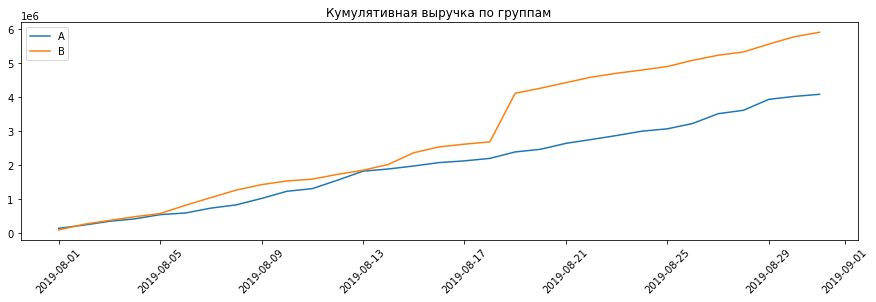

In [23]:
# построим графики кумулятивной выручки по группам:

plt.figure(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title ('Кумулятивная выручка по группам')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend();

В обеих группах выручка увеличивается в течение всего теста, хоть и немного разными темпами. В группе А рост более равномерный, тогда как в группе В мы наблюдаем резкий скачок выручки в середине теста, после которого разрыв между показателями в группах все сильнее увеличивался ( при этом количество заказов в этот период росло обычными темпами, поэтому вероятнее всего что мы имеем дело с одним или несколькими дорогими заказами).

К концу теста в группе В показатель кумулятивной выручки сильно опережал показатель в группе А.

### Кумулятивный средний чек по группам

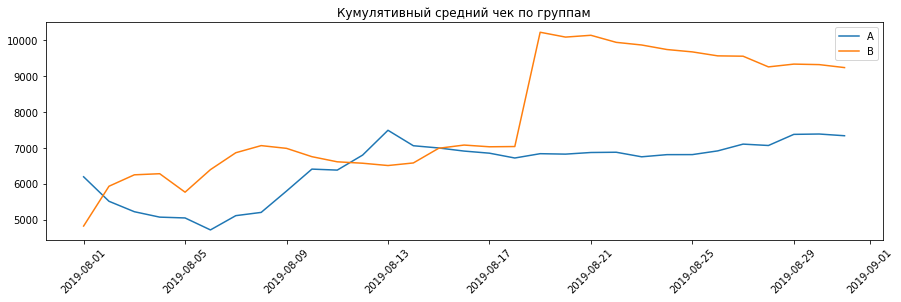

In [24]:
# определим кумулятивный средний чек для каждой из групп и построим график: 

plt.figure(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title ('Кумулятивный средний чек по группам')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend();

В начале теста показатель среднего чек в обеих группах постоянно меняется, однако уже с середины теста можно заметить некоторую стабилизацию. При этом в группе А это значение было достигнуто плавно, тогда как в группе В мы снова видим резкий скачок в середине теста (что подтверждает предположение о некотором количестве крупных заказов) и затем плавное снижение.

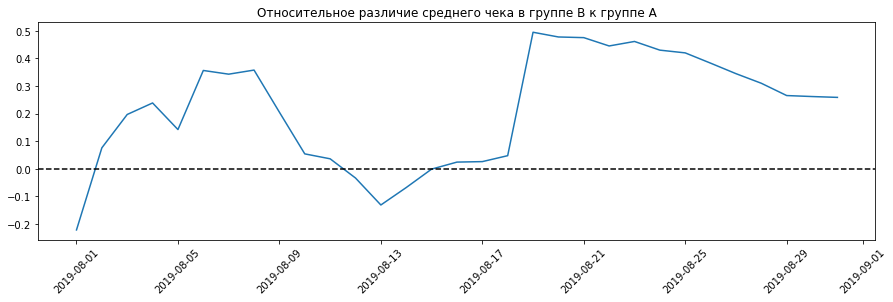

In [25]:
# соберем данные о кумулятивной выручке в одну таблицу:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# построим график относительного различия для среднего чека группы В к группе А
plt.figure(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title ('Относительное различие среднего чека в группе В к группе А')
plt.plot(mergedCumulativeRevenue['date'], (
    mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

Мы видим, что отношение среднего чека в группе В к среднему чеку в группе А постоянно меняется, и зачастую весьма резко, что также свидетельствует в пользу версии об отдельных дорогостоящих заказах. Во второй половине теста средний чек в группе В стабильно выше, чем в группе А, однако после некоторых скачков мы видим тенденцию к некоторому снижению этой разницы.

### Кумулятивное среднее количество заказов на пользователя по группам

In [26]:
# расчитаем среднее количество заказов на пользователя и добавим данные в новый столбец таблицы cumulativeData:

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

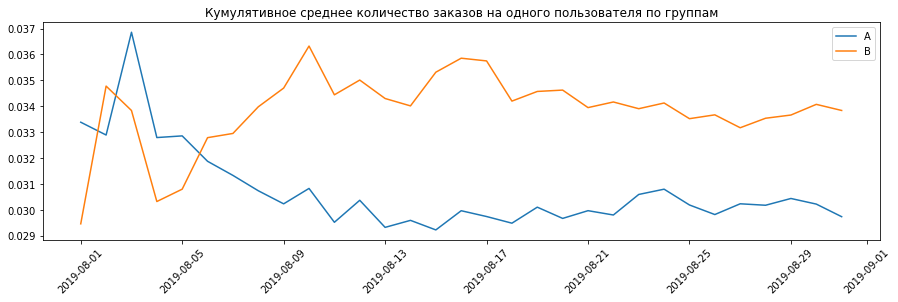

In [27]:
# построим графики кумулятивного среднего количества заказов по группам:

plt.figure(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title ('Кумулятивное среднее количество заказов на одного пользователя по группам')
plt.plot (cumulativeDataA['date'], cumulativeDataA['orders']/cumulativeDataA['visitors'], label='A')
plt.plot (cumulativeDataB['date'], cumulativeDataB['orders']/cumulativeDataB['visitors'], label='B')
plt.legend();

На графике заметно, что среднее число заказов на пользователя в группе В опередило аналогичный показатель в группе А практически в самом начале теста и после этого уже не уступал лидерство.

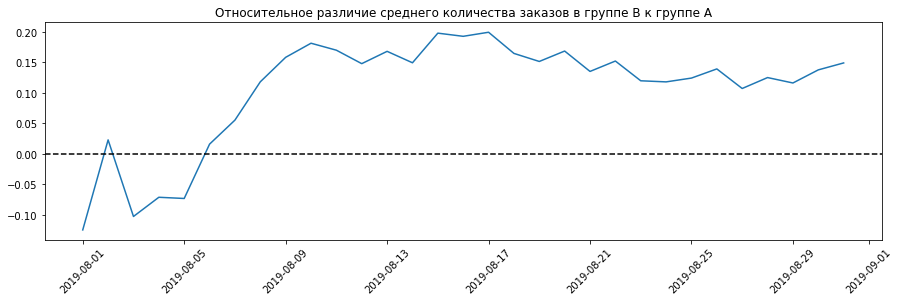

In [28]:
# построим график относительного различия для среднего количества группы В к группе А
plt.figure(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title ('Относительное различие среднего количества заказов в группе В к группе А')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['ordersB']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

Данный график наглядно иллюстрирует выводы, сделанные в результате анализы предыдущего графика: за исключением коротких периодов в начале теста, практически на всем его протяжении среднее количество заказов в группе В превышало аналогичный показатель в группе В. Мы видим резкий скачок этой разницы по окончании первой четверти теста, затем можно наблюдать определенную турбулентность с тенденцией к снижению.

### Количество заказов по пользователям

In [29]:
# Построим таблицу с информацией о количестве заказов для каждого пользователя:

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))


       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


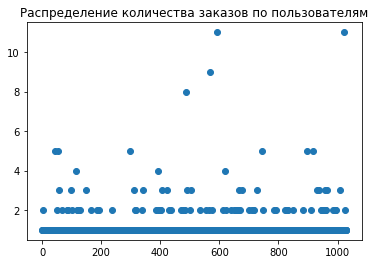

In [30]:
# Построим точечную диаграмму количества заказов на пользователя с помощью метода scatter()

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title ('Распределение количества заказов по пользователям');

Анализ диаграммы показывает,что подавляющее большинство пользователей совершают до трех заказов.

In [31]:
# Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Мы видим, что 10% пользователей оформили более одного заказа, 5% - более двух и лишь 1% оформили более 4 заказов. Представляется оправданным установить верхнюю границу для определения аномалий в 3 заказа на пользователя.

###  Стоимость заказов

,0
group,
B,0
B,1
A,2
B,3
B,4
...,...
B,1192
A,1193
A,1194


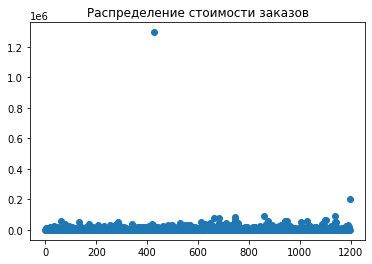

In [32]:
# Построим точечную диаграмму стоимости заказа с помощью метода scatter()

x_values = pd.DataFrame((range(0,len(orders['revenue']))), orders['group'])
display (x_values)
plt.scatter(x_values, orders['revenue'])
plt.title ('Распределение стоимости заказов'); 

Мы видим, что стоимость подавляющего большинства заказов не превышает отметки в 50 тысяч рублей.

In [33]:
# Посчитаем 95-й и 99-й перцентили стоимости заказов. 

print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Подсчет перцентилей показал, что стоимость 90% заказов не превышает 18 тысячи рублей, лишь 5% заказов дороже 28 тысяч рублей, и лишь 1% заказов дороже 58 тысяч рублей. Представляется оправданным установить верхнюю границу для определения аномалий в 30 тысяч рублей.

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным

Для начала сформулируем гипотезы. 

**Нулевая гипотеза**: различий в среднем количестве заказов между группами нет.     
 **Альтернативная гипотеза**: различия в среднем между группами есть.

In [34]:
# создадим переменные ordersByUsersA и ordersByUsersB и сохраним число заказов для каждого пользователя:

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsersA.columns = ['userId', 'orders']
print (ordersByUsersA.head(5))

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsersB.columns = ['userId', 'orders']
print (ordersByUsersB.head(5))

     userId  orders
0   8300375       1
1  11685486       1
2  54447517       1
3  66685450       1
4  78758296       1
     userId  orders
0   5114589       1
1   6958315       1
2   8300375       1
3  39475350       1
4  47206413       1


In [35]:
# создадим переменные с информацией о количестве посетителей каждый день для каждой из групп:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [36]:
# объявим переменные sampleA и sampleB, в которых 
# пользователям с заказами будет соответствовать число заказов пользователя,
# а пользователям без заказов — нули.

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(
    visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(
    visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 


In [37]:
# рассчитаем статистическую значимость различия среднего количества заказов с помощью теста Манна-Уитни

print ('Cтатистическая значимость различия среднего количества заказов по сырым данным:', stats.mannwhitneyu(sampleA, sampleB)[1])

Cтатистическая значимость различия среднего количества заказов по сырым данным: 0.016792355056752608


Получившийся p-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, необходимо отвергнуть** и принять альтернативную гипотезу **о наличии статистически значимой разницы в среднем числе заказов между группами А и В**. 

In [38]:
# выведем на экран значение относительного прироста среднего числа заказов группы B

print('Значение относительного прироста среднего числа заказов группы B по сравнению с группой А по сырым данным:' , "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Значение относительного прироста среднего числа заказов группы B по сравнению с группой А по сырым данным: 0.138


Относительный прирост среднего числа заказов в группе В по сравнению с группой А составляет 13,8 процентов

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Далее проверим статистическую значимость различий в среднем чеке между группами А и В. 

**Нулевая гипотеза:** различий в среднем чеке между группами нет.       
 **Альтернативная гипотеза:** различия в среднем чеке между группами есть.

In [39]:
# рассчитаем статистическую значимость различия среднего чека с помощью теста Манна-Уитни

print('Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным:', stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])

Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным: 0.7292909855432458


Получившийся p-value больше 0.05, следовательно, мы не отвергаем нулевую гипотезу об **отсутствии статистически значимых различий в среднем чеке в группах А и В**

In [40]:
# выведем на экран значение относительного прироста среднего чека в группе B:

print('значение относительного прироста среднего чека в группе B по сравнению с группой А по сырым данным:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1))

значение относительного прироста среднего чека в группе B по сравнению с группой А по сырым данным: 0.259


Относительный прирост значения среднего чека в группе В по сравнению с группой А составляет 25,9 процентов

### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

Для начала необходимо "очистить" данные от аномальных значений, находящихся за пределами верхних границ, определенных нами ранее (заказы не дороже 30 тысяч рублей и пользователи с количеством заказов не более трех)

In [41]:
# введем переменные для обозначения границы аномалий:
many_orders = 3
expensive_order = 30000

# сохраним в переменную usersWithManyOrders всех пользователей с количеством заказов больше 3:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > many_orders]['userId'],
     ordersByUsersB[ordersByUsersB['orders'] > many_orders]['userId'],],
    axis=0)

# сохраним в переменную usersWithExpensiveOrders пользователей с заказами дороже 30 тысяч рублей:
usersWithExpensiveOrders = orders[orders['revenue'] > expensive_order]['visitorId']

# объединим всех аномальных пользователей в таблице abnormalUsers и удалим дубликаты:
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates())

# посчитаем общее число аномальных пользователей:
print(abnormalUsers.shape[0])

57


Итак, всего было выявлено 57 аномальных пользователей, чьи действия могли существенно повлиять на результаты теста.

In [42]:
# подготовим выборки количества заказов по пользователям по группам теста и сохраним их в новые переменные:

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]
                             ['orders'],
    pd.Series(0, index=np.arange(
    visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]
                             ['orders'],
    pd.Series(0, index=np.arange(
    visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Теперь сформулируем гипотезы. 

**Нулевая гипотеза**: различий в среднем количестве заказов между группами нет.     
 **Альтернативная гипотеза**: различия в среднем между группами есть.

In [43]:
# рассчитаем статистическую значимость различия среднего количества заказов с помощью теста Манна-Уитни

print ('Cтатистическая значимость различия среднего количества заказов по очищенным данным:', 
       stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])

Cтатистическая значимость различия среднего количества заказов по очищенным данным: 0.01831750089424907


Получившийся p-value немного вырос, однако он все равно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, необходимо отвергнуть и принять альтернативную гипотезу **о наличии статистически значимой разницы в среднем числе заказов между группами А и В**.

In [44]:
# выведем на экран значение относительного прироста среднего числа заказов группы B

print('Значение относительного прироста среднего числа заказов группы B по сравнению с группой А по очищенным данным:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Значение относительного прироста среднего числа заказов группы B по сравнению с группой А по очищенным данным: 0.148


Относительный прирост среднего числа заказов в группе В по сравнению с группой А вырос на один процент по сравнению с "сырыми" данными и составляет 14,8 процентов

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Теперь проверим статистическую значимость различий в среднем чеке между группами А и В. 

**Нулевая гипотеза:** различий в среднем чеке между группами нет.       
 **Альтернативная гипотеза:** различия в среднем чеке между группами есть.

In [45]:
# рассчитаем статистическую значимость различия среднего чека с помощью теста Манна-Уитни

print('Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным:', stats.mannwhitneyu(
    orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[orders['group']=='B']['revenue'])[1])



Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным: 0.12636916446013835


Получившийся p-value значительно вырос и все ещё больше 0.05, следовательно, мы не отвергаем нулевую гипотезу об **отсутствии статистически значимых различий в среднем чеке в группах А и В**

In [46]:
# выведем на экран значение относительного прироста среднего чека в группе B:

print('значение относительного прироста среднего чека в группе B  по очищенным данным:', '{0:.3f}'.format(
    orders[np.logical_and (orders['group']=='B', np.logical_not(
    orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() /
        orders[np.logical_and (orders['group']=='A', np.logical_not(
        orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))
               

значение относительного прироста среднего чека в группе B  по очищенным данным: -0.020


Мы видим, что с учетом очищенных данных средний чек в группе В оказался даже **ниже, чем в группе А.**

## Результаты A/B-теста и выводы

По итогам проведенного A/B-теста можно сделать следующие выводы:
    
1) До фильтрации аномалий группа В показывала лучший результат практически по всем показателям, однако это было достигнуто за счет нескольких отдельных крупных заказов;     
 2) Есть статистически значимое различие по среднему количеству заказов между группами, причем оно наблюдается как по сырым данным, так и после фильтрации аномалий;    
  3) По среднему чеку статистически значимого различия между группами не наблюдается как по сырым данным, так и после фильтрации аномалий;     
   4) После фильтрации аномалий зафиксировано снижение среднего чека в группе В, тогда как до фильтрации он был значительно выше (на 25%).
   
Исходя из указанных результатов и тестируемой гипотезы (направленной на увеличение выручки) следует **остановить тест, признать его успешным, зафиксировать наличие различий между группами по среднему количеству заказов (в пользу группы В) и перейти к проверке следующей гипотезы.**